Necessary imports and styling

In [3]:
import csv
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker

plt.style.use("ggplot")

# Weight anaylisis

Storing teams data entries from csv file

In [4]:
# Var ini
path = "FSAE_2023_results/FSAE_2023_results - Team information.csv"

entries = dict()

# Opening file with context manager and parsing it with csv module
with open(path) as file:
    reader = csv.DictReader(file, restval = "help")
    # Initializing total entry of averages and amount
    entries["TOTAL"] = list()

    for entry in reader:
        # Get displacement and weight, casting the latter
        displacement = entry["Engine Displacement (cc)"]
        # If it's not a valid value, then it'll skip to the next entry
        try:
            weight = float(entry["Weight(kg)"])
        except ValueError:
            continue

        # Storing displacement entry 
        if displacement not in entries:
            entries[displacement] = list()
        
        # Storing data per entry
        entries["TOTAL"].append(weight)
        entries[displacement].append(weight)


# Casting into np.arrays for faster computing
for category in entries:
    entries[category] = np.array(entries[category])


Computing averages and plotting them

AVERAGE WEIGHT PER ENGINE DISPLACEMENT
Category: Average, Cars 
     250:  254.50,    1
     300:  245.40,    1
     320:  187.30,    1
     450:  184.38,   17
     470:  212.30,    1
     478:  166.95,    2
     500:  204.70,    3
     600:  226.30,   61
     625:  248.10,    1
     627:  186.40,    1
     636:  226.21,    8
     650:  234.30,    2
     670:  213.60,    1
     675:  216.67,    3
     689:  199.10,    1
     690:  212.73,    7
     700:  218.60,    1
   TOTAL:  216.69,  112


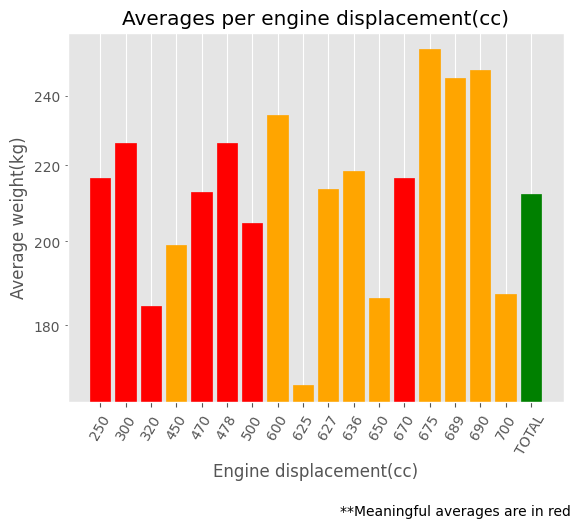

In [8]:
# Avrg computing
averages = dict()

# Storing averages and amount of cars per category for classification
for category in entries:
    averages[category] = (np.mean(entries[category]), len(entries[category]))

print("AVERAGE WEIGHT PER ENGINE DISPLACEMENT", "Category: Average, Cars ", sep="\n")
for category in sorted(averages):
    print(f"{category:>8}: {averages[category][0]:>7.2f}, {averages[category][1]:>4}")

# Plotting
fig, ax = plt.subplots()

X = np.arange(len(averages))
Y = np.array([x[0] for x in averages.values()])

barlist = ax.bar(X, Y)

# Formatting plot
ax.set_title("Averages per engine displacement(cc)")
ax.set_xlabel("Engine displacement(cc)")
ax.set_ylabel("Average weight(kg)")
plt.figtext(0.55, -0.125, "**Meaningful averages are in red")


ax.set_yscale("log")
ax.yaxis.set_minor_formatter(ticker.ScalarFormatter())

x_ticks = sorted([key for key in averages.keys()])
ax.set_xticks(np.arange(len(x_ticks)) ,labels=x_ticks)
plt.xticks(rotation=60)

# Coloring based on valid data
for i, key in enumerate(sorted(averages)):
    if  averages[key][1] < 3:
        barlist[i].set_color('orange')
    else:
        barlist[i].set_color('red')
barlist[-1].set_color('green')
